# Урок 4. Построение алгоритма дерева решений

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np
import pandas as pd

In [2]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450,
               800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 
               1, 3, 3, 1, 2]], dtype = np.float64)

y = np.array([0, 0, 1, 0, 1,
              0, 1, 0, 1, 1], dtype = np.float64)

Неопределенность Джини (Gini impurity): $$G = \sum\limits_k p_k(1 - p_k)^2$$

 ### ООП реализация

In [3]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [4]:
# И класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction_classification = self.predict()
        self.prediction_regression = self.predict_reg()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction  

    def predict_reg(self):
        #  найдем значение как среднее по выборке   
        prediction = np.mean(self.labels)
        return prediction  

In [5]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [6]:
# Расчет качества для задачи классификации
def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [7]:
# Разбиение датасета в узле
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [8]:
# Нахождение наилучшего разбиения для задачи классификации
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

HW 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

#### Так как критерии количество листьев и глубина уже реализованы, сделал органичение по количеству используемых признаков (max_features):

In [33]:
# Построение дерева классификации с помощью рекурсивной функции
def build_tree_classification(data, labels, tree_depth=1, max_depth=50, max_features = 3):
    
    if data.shape[1]>max_features:
        data = data[:,:max_features]  # 'срезаем' признаки, если их количество больше параметра max_features
        print(f'признаков в данных: {data.shape[1]}')
    
    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    # Базовый случай (2) - прекращаем рекурсию, когда достигнута максимальная глубина дерева
    if tree_depth >= max_depth:
        return Leaf(data, labels)

    # Увеличиваем глубину дерева на 1
    tree_depth += 1

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_classification(true_data, true_labels, tree_depth, max_depth)
    false_branch = build_tree_classification(false_data, false_labels, tree_depth, max_depth)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [10]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction_classification
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [11]:
def predict_class(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

## Проверим работоспособность дерева классификации


In [24]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 5, n_informative = 5, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=2020)

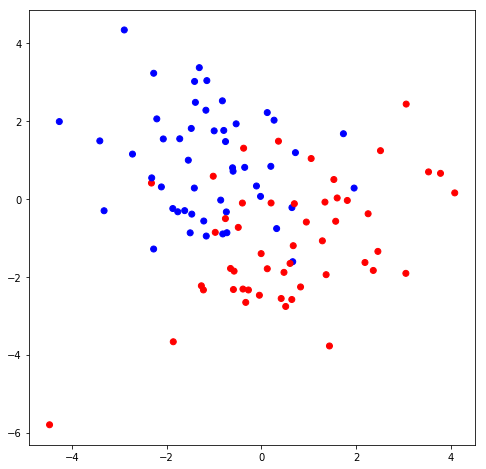

In [28]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [29]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [31]:
train_data.shape[1] # количество признаков больше максимального

5

In [34]:
my_tree_classification = build_tree_classification(train_data, train_labels)

признаков в данных: 3


In [35]:
# Напечатаем ход нашего дерева
def print_tree_classification(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction_classification)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree_classification(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree_classification(node.false_branch, spacing + "  ")
    


In [18]:
print_tree_classification(my_tree_classification)

Индекс 1
Порог -0.213517785132452
--> True:
  Индекс 1
  Порог -1.0358125892015055
  --> True:
    Прогноз: 0
  --> False:
    Индекс 1
    Порог -0.7215308042303363
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 0
--> False:
  Индекс 1
  Порог 0.22860279010454132
  --> True:
    Прогноз: 1
  --> False:
    Индекс 1
    Порог 1.4997225580925082
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 1


In [19]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [20]:
# import os
# path_to_graphviz = '/home/n-bar/anaconda3/lib/python3.7/site-packages/graphviz' # your path to graphviz (C:\\Program Files (x86)\\Graphviz2.38\\bin\\ for example) 
# os.environ["PATH"] += os.pathsep + path_to_graphviz

### Домашнее задание. 

1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)  
2*. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [36]:
# Расчёт дисперсии значений (вместо gini)
def dispersion(labels):
    return np.var(labels)


# Расчет качества для задачи регрессии
def quality_regression(left_labels, right_labels, current_dispersion):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_dispersion - p * dispersion(left_labels) - (1 - p) * dispersion(right_labels)


# аналог classify_object для регрессии
def predict_object(obj, node):
    
    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction_regression
        return answer

    if obj[node.index] <= node.t:
        return predict_object(obj, node.true_branch)
    else:
        return predict_object(obj, node.false_branch)

    
# аналог predict_class для регрессии
def predict_value(data, tree):
    
    val = []
    for obj in data:
        prediction = predict_object(obj, tree)
        val.append(prediction)
    return val
    

# Нахождение наилучшего разбиения для задачи регрессии
def find_best_split_regression(data, labels, min_leaf=5):

    current_dispersion = dispersion(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality_regression(true_labels, false_labels, current_dispersion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index


# Построение дерева регрессии с помощью рекурсивной функции
def build_tree_regression(data, labels, tree_depth=1, max_depth=50, max_features=3):

    if data.shape[1]>max_features:
        data = data[:,:max_features]  # 'срезаем' признаки, если их количество больше параметра max_features
        print(f'признаков в данных: {data.shape[1]}')
    
    quality, t, index = find_best_split_regression(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    # Базовый случай (2) - прекращаем рекурсию, когда достигнута максимальная глубина дерева
    if tree_depth >= max_depth:
        return Leaf(data, labels)

    # Увеличиваем глубину дерева на 1
    tree_depth += 1

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_regression(true_data, true_labels, tree_depth, max_depth)
    false_branch = build_tree_regression(false_data, false_labels, tree_depth, max_depth)


    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)


In [110]:
# сгенерируем данные
regression_data, regression_labels = datasets.make_regression(n_features = 4, n_informative = 4,
                                                              bias = 10.0, noise=0.0,
                                                      random_state=2020, n_samples = 100)

In [111]:
regression_data.shape

(100, 4)

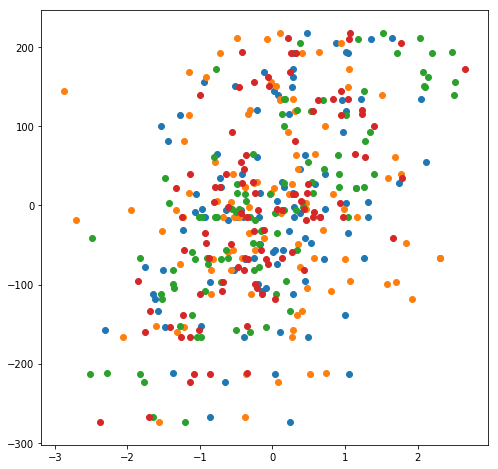

In [113]:
plt.figure(figsize=(8,8))
plt.scatter(regression_data[:,0], regression_labels)
plt.scatter(regression_data[:,1], regression_labels)
plt.scatter(regression_data[:,2], regression_labels)
plt.scatter(regression_data[:,3], regression_labels)



In [114]:
# Разобьем выборку на обучающую и тестовую

train_data_reg, test_data_reg, train_labels_reg, test_labels_reg = model_selection.train_test_split(regression_data, 
                                                                                     regression_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [115]:
my_tree_regression = build_tree_regression(train_data_reg, train_labels_reg)

признаков в данных: 3


In [116]:
train_answers = predict_value(train_data_reg, my_tree_regression)

In [117]:
answers = predict_value(test_data_reg, my_tree_regression)

In [85]:
def mse_metric(actual, predicted):
    return np.average((actual - predicted)**2, axis = 0)

In [118]:
train_mse = mse_metric(train_labels_reg, train_answers)
train_mse

3398.684630849012

In [119]:
test_mse = mse_metric(test_labels_reg, answers)
test_mse

9697.39707129705

In [120]:
# Напечатаем ход нашего дерева
def print_tree_regression(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction_regression)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree_regression(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree_regression(node.false_branch, spacing + "  ")
    


In [89]:
print_tree_regression(my_tree_regression)

Индекс 1
Порог -0.06115443195334841
--> True:
  Индекс 1
  Порог -0.7961413076110453
  --> True:
    Индекс 1
    Порог -1.3615020810282137
    --> True:
      Прогноз: -116.90446727825281
    --> False:
      Индекс 1
      Порог -1.1030377987266975
      --> True:
        Прогноз: -69.87049004662776
      --> False:
        Прогноз: -69.58849051864844
  --> False:
    Индекс 1
    Порог -0.48820740218959235
    --> True:
      Прогноз: -39.30732673571772
    --> False:
      Индекс 0
      Порог -0.2565263674555911
      --> True:
        Прогноз: -19.503074445083183
      --> False:
        Прогноз: 0.890817477973244
--> False:
  Индекс 1
  Порог 1.033832958550941
  --> True:
    Индекс 1
    Порог 0.4101129497994469
    --> True:
      Индекс 0
      Порог 0.05729383491769795
      --> True:
        Прогноз: 24.61109036983177
      --> False:
        Прогноз: 35.14025065696682
    --> False:
      Индекс 0
      Порог 0.27987266232880875
      --> True:
        Прогноз: 48.39633469